# PyTorch Fundamentals

## Perceptron

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

### Simple Perceptron

#### Prepare the dataset

In [ ]:
data = """0.77,-1.14,0\n-0.33,1.44,0\n0.91,-3.07,0\n-0.37,-1.91,0\n-1.84,-1.13,0\n-1.50,0.34,0\n-0.63,-1.53,0\n-1.08,-1.23,0\n0.39,-1.99,0\n-1.26,-2.90,0\n-5.27,-0.78,0\n-0.49,-2.74,0\n1.48,-3.74,0\n-1.64,-1.96,0\n0.45,0.36,0\n-1.48,-1.17,0\n-2.94,-4.47,0\n-2.19,-1.48,0\n0.02,-0.02,0\n-2.24,-2.12,0\n-3.17,-3.69,0\n-4.09,1.03,0\n-2.41,-2.31,0\n-3.45,-0.61,0\n-3.96,-2.00,0\n-2.95,-1.16,0\n-2.42,-3.35,0\n-1.74,-1.10,0\n-1.61,-1.28,0\n-2.59,-2.21,0\n-2.64,-2.20,0\n-2.84,-4.12,0\n-1.45,-2.26,0\n-3.98,-1.05,0\n-2.97,-1.63,0\n-0.68,-1.52,0\n-0.10,-3.43,0\n-1.14,-2.66,0\n-2.92,-2.51,0\n-2.14,-1.62,0\n-3.33,-0.44,0\n-1.05,-3.85,0\n0.38,0.95,0\n-0.05,-1.95,0\n-3.20,-0.22,0\n-2.26,0.01,0\n-1.41,-0.33,0\n-1.20,-0.71,0\n-1.69,0.80,0\n-1.52,-1.14,0\n3.88,0.65,1\n0.73,2.97,1\n0.83,3.94,1\n1.59,1.25,1\n3.92,3.48,1\n3.87,2.91,1\n1.14,3.91,1\n1.73,2.80,1\n2.95,1.84,1\n2.61,2.92,1\n2.38,0.90,1\n2.30,3.33,1\n1.31,1.85,1\n1.56,3.85,1\n2.67,2.41,1\n1.23,2.54,1\n1.33,2.03,1\n1.36,2.68,1\n2.58,1.79,1\n2.40,0.91,1\n0.51,2.44,1\n2.17,2.64,1\n4.38,2.94,1\n1.09,3.12,1\n0.68,1.54,1\n1.93,3.71,1\n1.26,1.17,1\n1.90,1.34,1\n3.13,0.92,1\n0.85,1.56,1\n1.50,3.93,1\n2.95,2.09,1\n0.77,2.84,1\n1.00,0.46,1\n3.19,2.32,1\n2.92,2.32,1\n2.86,1.35,1\n0.97,2.68,1\n1.20,1.31,1\n1.54,2.02,1\n1.65,0.63,1\n1.36,-0.22,1\n2.63,0.40,1\n0.90,2.05,1\n1.26,3.54,1\n0.71,2.27,1\n1.96,0.83,1\n2.52,1.83,1\n2.77,2.82,1\n4.16,3.34,1"""

with open('perceptron_toydata.txt', 'w') as f:
    f.write(data)

In [ ]:
data = np.genfromtxt('perceptron_toydata.txt', delimiter=',')
X, y = data[:, :2], data[:, 2]
y = y.astype(np.int)

print('Class label counts:', np.bincount(y))
print('X.shape:', X.shape)
print('y.shape:', y.shape)

# Shuffling & train/test split
shuffle_idx = np.arange(y.shape[0])
shuffle_rng = np.random.RandomState(123)
shuffle_rng.shuffle(shuffle_idx)
X, y = X[shuffle_idx], y[shuffle_idx]

X_train, X_test = X[shuffle_idx[:70]], X[shuffle_idx[70:]]
y_train, y_test = y[shuffle_idx[:70]], y[shuffle_idx[70:]]

# Normalize (mean zero, unit variance)
mu, sigma = X_train.mean(axis=0), X_train.std(axis=0)
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

Class label counts: [50 50]
X.shape: (100, 2)
y.shape: (100,)


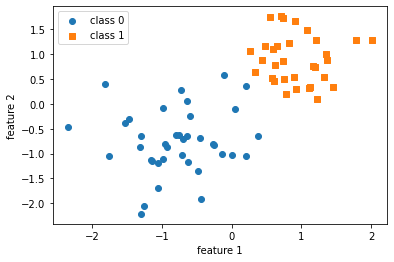

In [ ]:
plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')
plt.xlabel('feature 1')
plt.ylabel('feature 2')
plt.legend()
plt.show()

#### Defining the Perceptron model

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def custom_where(cond, x_1, x_2):
    return (cond.long() * x_1) + ((1-cond.long()) * x_2)


class Perceptron():
    def __init__(self, num_features):
        self.num_features = num_features
        self.weights = torch.zeros(num_features, 1, 
                                   dtype=torch.float32, device=device)
        self.bias = torch.zeros(1, dtype=torch.float32, device=device)

    def forward(self, x):
        linear = torch.add(torch.mm(x, self.weights), self.bias)
        predictions = custom_where(linear > 0., 1, 0).float()
        return predictions
        
    def backward(self, x, y):  
        predictions = self.forward(x)
        errors = y - predictions
        return errors
        
    def train(self, x, y, epochs):
        for e in range(epochs):
            
            for i in range(y.size()[0]):
                # use view because backward expects a matrix (i.e., 2D tensor)
                errors = self.backward(x[i].view(1, self.num_features), y[i]).view(-1)
                self.weights += (errors * x[i]).view(self.num_features, 1)
                self.bias += errors
                
    def evaluate(self, x, y):
        predictions = self.forward(x).view(-1)
        accuracy = torch.sum(predictions == y).float() / y.size()[0]
        return accuracy

#### Training the Perceptron

In [ ]:
ppn = Perceptron(num_features=2)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)

ppn.train(X_train_tensor, y_train_tensor, epochs=5)

print('Model parameters:')
print('  Weights: %s' % ppn.weights)
print('  Bias: %s' % ppn.bias)

Model parameters:
  Weights: tensor([[1.2734],
        [1.3464]])
  Bias: tensor([-1.])


#### Evaluating the model

In [ ]:
X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

test_acc = ppn.evaluate(X_test_tensor, y_test_tensor)
print('Test set accuracy: %.2f%%' % (test_acc*100))

Test set accuracy: 93.33%


#### 2D Decision Boundary

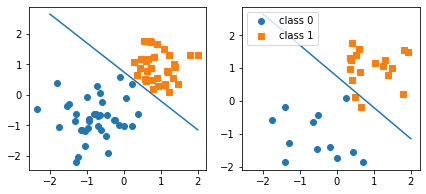

In [ ]:
w, b = ppn.weights, ppn.bias

x_min = -2
y_min = ( (-(w[0] * x_min) - b[0]) 
          / w[1] )

x_max = 2
y_max = ( (-(w[0] * x_max) - b[0]) 
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(7, 3))

ax[0].plot([x_min, x_max], [y_min, y_max])
ax[1].plot([x_min, x_max], [y_min, y_max])

ax[0].scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], label='class 0', marker='o')
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='class 1', marker='s')

ax[1].scatter(X_test[y_test==0, 0], X_test[y_test==0, 1], label='class 0', marker='o')
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='class 1', marker='s')

ax[1].legend(loc='upper left')
plt.show()

## Deploying PyTorch to Production

**torchscript, torchserve, Flask, ONNX**

In the past, going from research to production was a challenging task that required a team of software engineers to move PyTorch models to a framework and integrate them nto a (often non-Python) production environment. Today, PyTorch includes built-in tools and external libraries to support rapid deployment to a variety of production environments.

We will focus on deploying your model for inference, not training, and we’ll explore how to deploy your trained PyTorch models into a variety of applications. First, I’ll describe the various built-in capabilities and tools within PyTorch that you can use for deployment. Tools like TorchServe and TorchScript allow you to easily deploy your PyTorch models to the cloud and to mobile or edge devices.

Depending on the application and environment, you may have several options for deployment, each with its own trade-offs. I’ll show you examples of how you can deploy your PyTorch models in multiple cloud and edge environments. You’ll learn how to deploy to web servers for development and production at scale, to iOS and Android mobile devices, and to Internet of Things (IoT) devices based on ARM processors, GPUs, and field-programmable gate array (FPGA) hardware.

Table below summarizes the various resources available for deployment and indicates how to appropriately use each one.

| Resource | Use |
| -------- | --- |
| Python API | Perform fast prototyping, training, and experimentation; program Python runtimes. |
| TorchScript | Improve performance and portability (e.g., load and run a model in C++); </br>program non-Python runtimes or strict latency and performance requirements. |
| TorchServe | A fast production environment tool with model store, A/B testing, monitoring, and RESTful API. |
| ONNX | Deploy to systems with ONNX runtimes or FPGA devices. |
| Mobile libraries | Deploy to iOS and Android devices. |

 For our examples, we’ll deploy an image classifier using a VGG16 model pretrained with ImageNet data. That way, each section can focus on the deployment approach used and not the model itself. For each approach, you can replace the VGG16 model with one of your own and follow the same workflow to achieve results with your own designs.

In [ ]:
import numpy as np
from torchvision.models import vgg16

model = vgg16(pretrained=True)

model_parameters = filter(lambda p: 
      p.requires_grad, model.parameters())

params = sum([np.prod(p.size()) for 
      p in model_parameters])
print(params)

In [ ]:
import torch
torch.save(model.state_dict(), "./vgg16_model.pt")

The VGG16 model has 138,357,544 trainable parameters. As we go through each approach, keep in mind the performance at this level of complexity. You can use this as a rough benchmark when comparing the complexity of your models.

After we instantiate the VGG16 model, it requires minimal effort to deploy it in a Python application.

> Tip: Python is not always used in production environments due to its slower performance and lack of true multithreading. If your production environment uses another language (e.g., C++, Java, Rust, or Go), you can convert your models to TorchScript code.

TorchScript is a way to serialize and optimize your PyTorch model code so that your PyTorch models can be saved and executed in non-Python runtime environments with no dependency on Python. TorchScript is commonly used to run PyTorch models in C++ and with any language that supports C++ bindings.

TorchScript represents a PyTorch model in a format that can be understood, compiled, and serialized by the TorchScript compiler. The TorchScript compiler creates a serialized, optimized version of your model that can be used in C++ applications. To load your TorchScript model in C++, you would use the PyTorch C++ API library called LibTorch.

There are two ways to convert your PyTorch models to TorchScript. The first one is called tracing, which is a process in which you pass in an example input and perform the conversion with one line of code. It’s used in most cases. The second is called scripting, and it’s used when your model has more complex control code. For example, if your model has conditional if statements that depend on the input itself, you’ll want to use scripting. Let’s take a look at some reference code for each case.

Since our VGG16 example model does not have any control flow, we can use tracing to convert our model to TorchScript, as shown in the following code:

In [ ]:
import torch

model = vgg16(pretrained=True)
example_input = torch.rand(1, 3, 224, 224)
torchscript_model = torch.jit.trace(model,
                            example_input)
torchscript_model.save("traced_vgg16_model.pt")

If our model used control flow, we would need to use the annotation method to convert it to TorchScript. Let’s consider the following model:

In [ ]:
import torch.nn as nn

class ControlFlowModel(nn.Module):
  def __init__(self, N):
    super(ControlFlowModel, self).__init__()
    self.fc = nn.Linear(N,100)

  def forward(self, input):
    if input.sum() > 0:
      output = input
    else:
      output = -input
    return output

model = ControlFlowModel(10)
torchcript_model = torch.jit.script(model)
torchscript_model.save("scripted_vgg16_model.pt")

Now we can use our model in a C++ application, as shown in the following C++ code:

```cpp
include <torch/script.h>

#include <iostream>
#include <memory>

int main(int argc, const char* argv[]) {
  if (argc != 2) {
    std::cerr << "usage: example-app" >> \
      "<path-to-exported-script-module>\n";
    return -1;
  }

  torch::jit::script::Module model;
  model = torch::jit::load(argv[1]);

  std::vector<torch::jit::IValue> inputs;
  inputs.push_back( \
      torch::ones({1, 3, 224, 224}));

  at::Tensor output = model.forward(inputs).toTensor();
  std::cout \
    << output.slice(/*dim=*/1, \
        /*start=*/0, /*end=*/5) \
    << '\N';
  }

}
```

In this section, we used TorchScript to increase the performance of our model when it’s used in a C++ application or in a language that binds to C++. However, deploying PyTorch models at scale requires additional capabilities, like packaging models, configuring runtime environments, exposing API endpoints, logging and monitoring, and managing multiple model versions. Fortunately, PyTorch provides a tool called TorchServe to facilitate these tasks and rapidly deploy your models for inference at scale.

TorchServe is an open-source model-serving framework that makes it easy to deploy trained PyTorch models. It was developed by AWS engineers and jointly released with Facebook in April 2020, and it is actively maintained by AWS. TorchServe supports all the features needed to deploy models to production at scale, including multimodel serving, model versioning for A/B testing, logging and metrics for monitoring, and a RESTful API for integration with other systems.

<img src='https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F2517df91-579d-4794-850a-8c039627e8e7%2FUntitled.png?table=block&id=b0e70d51-7a61-4cc1-bbdf-f1737eccef0a&spaceId=63b72b1f-0e90-4ab8-a6df-a060a6545a56&width=2000&userId=21ec183f-f0be-4b6b-9b3e-6f0d4e5c5469&cache=v2'>

The client application interfaces with TorchServe through multiple APIs. The Inference API provides the main inference requests and predictions. The client application sends input data through the RESTful API request and receives the prediction results. The Management API allows you to register and manage your deployed models. You can register, unregister, set default models, configure A/B testing, check status, and specify the number of workers for a model. The Metrics API allows you to monitor each model’s performance.

TorchServe runs all model instances and captures server logs. It processes the frontend APIs and manages the model storage to disk. TorchServe also provides a number of default handlers for common applications like object detection and text classification. The handlers take care of converting data from the API into a format that your model will process. This helps speed up deployment since you don’t have to write custom code for these common applications.

To deploy your models via TorchServe, you will need to follow a few steps. First you need to install TorchServe’s tools. Then you’ll package your model using the model archiver tool. Once your models are archived, you’ll then run the TorchServe web server. Once the web server is running, you can use its APIs to request predictions, manage your models, perform monitoring, or access server logs.

In [ ]:
!pip install torchserve torch-model-archiver
!pip install image_classifier captum

TorchServe has the ability to package all model artifacts into a single-model archive file. To do so, we will use the torch-model-archiver command-line tool that we installed in the previous step. It packages model checkpoints as well as the state_dict into a .mar file that the TorchServe server uses to serve the model.

You can use the torch-model-archiver to archive your TorchScript models as well as the standard “eager-mode” implementations, as shown in the following code.

In [ ]:
!torch-model-archiver --model-name vgg16 \
  --version 1.0 --serialized-file traced_vgg16_model.pt --handler \
  image_classifier

In [ ]:
!mkdir -p /content/models && mv ./*.mar /content/models

TorchServe includes a built-in web server that is run from the command line. It wraps one or more PyTorch models in a set of REST APIs and provides controls for configuring the port, host, and logging. The following command starts the web server with all models in the model store located in the /models folder:

In [ ]:
%%writefile config.properties
inference_address=https://0.0.0.0:8091
management_address=https://0.0.0.0:8092
metrics_address=https://0.0.0.0:8093

Writing config.properties


In [ ]:
!nohup torchserve --model-store ./models --start --models all --ts-config ./config.properties --ncs --foreground &

nohup: appending output to 'nohup.out'


In [ ]:
!tail nohup.out

Maximum Request Size: 6553500
Prefer direct buffer: false
Allowed Urls: [file://.*|http(s)?://.*]
Custom python dependency for model allowed: false
Metrics report format: prometheus
Enable metrics API: true
Workflow Store: /content/models
Model config: N/A
2021-09-09 09:06:58,146 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager -  Loading snapshot serializer plugin...
2021-09-09 09:06:58,187 [DEBUG] main org.pytorch.serve.ModelServer - Loading models from model store: vgg16.mar


In [ ]:
!wget -O hotdog.jpg -q --show-progress https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTk5onR1hxG2h_yGFkgZvLVu7b7IY2PIuekKaagBG0nYFsqktcIwjYu6a7LT6OjTfEHWAU&usqp=CAU

hotdog.jpg          100%[===================>]   8.19K  --.-KB/s    in 0s      


In [ ]:
!curl --insecure https://localhost:8091/ping

{
  "status": "Healthy"
}


In [ ]:
!curl --insecure https://localhost:8091/predictions/vgg16 -T hotdog.jpg

{
  "930": 0.5350928902626038,
  "934": 0.45859622955322266,
  "932": 0.0020345677621662617,
  "964": 0.001944492687471211,
  "415": 0.0007812475669197738
}

In [ ]:
!torchserve --stop

TorchServe has stopped.


You can configure metrics using the Metrics API and monitor and log your models’ performance when deployed.

In [ ]:
!curl --insecure https://127.0.0.1:8093/metrics

# HELP ts_inference_latency_microseconds Cumulative inference duration in microseconds
# TYPE ts_inference_latency_microseconds counter
ts_inference_latency_microseconds{uuid="e353233e-e7fb-47a9-b7f2-47375e8a105b",model_name="vgg16",model_version="default",} 1468713.732
# HELP ts_queue_latency_microseconds Cumulative queue duration in microseconds
# TYPE ts_queue_latency_microseconds counter
ts_queue_latency_microseconds{uuid="e353233e-e7fb-47a9-b7f2-47375e8a105b",model_name="vgg16",model_version="default",} 434.962
# HELP ts_inference_requests_total Total number of inference requests.
# TYPE ts_inference_requests_total counter
ts_inference_requests_total{uuid="e353233e-e7fb-47a9-b7f2-47375e8a105b",model_name="vgg16",model_version="default",} 2.0


The default metrics endpoint returns Prometheus-formatted metrics. Prometheus is a free software application used for event monitoring and alerting that records real-time metrics in a time series database built using an HTTP pull model. You can query metrics using curl requests or point a Prometheus Server to the endpoint and use Grafana for dashboards.

In [ ]:
!ls -al ./logs

total 364
drwxr-xr-x 3 root root   4096 Sep  9 08:42 .
drwxr-xr-x 1 root root   4096 Sep  9 09:06 ..
-rw-r--r-- 1 root root    603 Sep  9 09:10 access_log.log
drwxr-xr-x 2 root root   4096 Sep  9 09:02 config
-rw-r--r-- 1 root root 179426 Sep  9 09:07 model_log.log
-rw-r--r-- 1 root root    717 Sep  9 09:07 model_metrics.log
-rw-r--r-- 1 root root 158503 Sep  9 09:11 ts_log.log
-rw-r--r-- 1 root root   2999 Sep  9 09:10 ts_metrics.log


Metrics are logged to a file. TorchServe also supports other types of server logging, including access logs and TorchServe logs. Access logs record the inference requests and the time it takes to complete the requests. As defined in the properties file, the access logs are collected in the <log_location>/access_log.log file. TorchServe logs collect all the logs from TorchServe and its backend workers.

TorchServe supports capabilities beyond the default settings for metrics and logging. Metrics and logging can be configured in many different ways. In addition, you can create custom logs. For more information on metric and logging customization and other advanced features of TorchServe, refer to the TorchServe documentation.

The NVIDIA Triton Inference Server is becoming more popular and is also used to deploy AI models at scale in production. Although not part of the PyTorch project, you may want to consider the Triton Inference Server as an alternative to TorchServe, especially when deploying to NVIDIA GPUs.

The Triton Inference Server is open source software and can load models from local storage, GCP, or AWS S3. Triton supports running multiple models on single or multiple GPUs, low latency and shared memory, and model ensembles. Some possible advantages of Triton over TorchServe include:

- Triton is out of beta.
- It is the fastest way to infer on NVIDIA hardware (common).
- It can use int4 quantization.
- You can port directly from PyTorch without ONNX.

Available as a Docker container, Triton Inference Server also integrates with Kubernetes for orchestration, metrics, and auto-scaling. For more information, visit the NVIDIA Triton Inference Server documentation.

If your platform doesn’t support PyTorch and you cannot use TorchScript/C++ or TorchServe for your deployment, it may be possible that your deployment platform supports the Open Neural Network Exchange (ONNX) format. The ONNX format defines a common set of operators and a common file format so that deep learning engineers can use models across a variety of frameworks, tools, runtimes, and compilers.

ONNX was developed by Facebook and Microsoft to allow model interoperability between PyTorch and other frameworks, such as Caffe2 and Microsoft Cognitive Toolkit (CTK). ONNX is currently supported by inference runtimes from a number of providers, including Cadence Systems, Habana, Intel AI, NVIDIA, Qualcomm, Tencent, Windows, and Xilinx.

An example use case is edge deployment on a Xilinx FPGA device. FPGA devices are custom chips that can be programmed with specific logic. They are used by edge devices for low-latency or high-performance applications, like video. If you want to deploy your new innovative model to an FPGA device, you would first convert it to ONNX format and then use the Xilinx FPGA development tools to generate an FPGA image with your model’s implementation.

Let’s take a look at an example of how to export a model to ONNX, again using our VGG16 model. The ONNX exporter can use tracing or scripting. We learned about tracing and scripting, described in the earlier section on TorchScript. We can use tracing by simply providing the model and an example input. The following code shows how we’d export our VGG16 model to ONNX using tracing:

In [ ]:
!pip install onnx

In [ ]:
import onnx

model = vgg16(pretrained=True)
example_input = torch.rand(1, 3, 224, 224)
onnx_model = torch.onnx.export(model, 
                               example_input, 
                               "vgg16.onnx")

We define an example input and call torch.onnx.export(). The resulting file, vgg16.onnx, is a binary protobuf file that contains both the network structure and the parameters of the VGG16 model we exported.

If we want to verify that our model was converted to ONNX properly, we can use the ONNX checker, as shown in the following code:

In [ ]:
model = onnx.load("vgg16.onnx")
onnx.checker.check_model(model)
onnx.helper.printable_graph(model.graph)

This code uses the Python ONNX library to load the model, run the checker, and print out a human-readable version of the model.

Before deploying to full-scale production, you may want to deploy your models to a development web server. This enables you to integrate your deep learning algorithms with other systems and quickly build prototypes to demonstrate your new models. One of the easiest ways to build a development server is with Python using Flask.

Flask is a simple micro web framework written in Python. It is called a “micro” framework because it does not include a database abstraction layer, form validation, upload handling, various authentication technologies, or anything else that might be provided with other libraries. We won’t cover Flask in depth in this book, but I’ll show you how to use Flask to deploy your models in Python.

We’ll also expose a REST API so that other applications can pass in data and receive predictions. In the following examples, we’ll deploy our pretrained VGG16 model and classify images. First we’ll define our API endpoints, request types, and response types. Our API endpoint will be at /predict, which takes in POST requests (including the image file). The response will be in JSON format and contain a class_id and class_name from the ImageNet dataset.

Since our model will return a number indicating the class, we’ll need a lookup table to convert this number to a class name. We create a dictionary called imagenet_class_index by reading in the JSON conversion file. We then instantiate our VGG16 model and define our image transforms to preprocess a PIL image by resizing it, center-cropping it, converting it to a tensor, and normalizing it. These steps are required prior to sending the image into our model.

In [ ]:
!wget -q --show-progress "https://raw.githubusercontent.com/raghakot/keras-vis/master/resources/imagenet_class_index.json"

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0s      


In [ ]:
import socket
print(socket.gethostbyname(socket.getfqdn(socket.gethostname())))

import io
import json

from torchvision import models
import torchvision.transforms as transforms
from PIL import Image
from flask import Flask, jsonify, request

app = Flask(__name__)

imagenet_class_index = json.load(
    open("./imagenet_class_index.json"))

model = models.vgg16(pretrained=True)

image_transforms = transforms.Compose(
    [transforms.Resize(255),
     transforms.CenterCrop(224),
     transforms.ToTensor(),
     transforms.Normalize(
          [0.485, 0.456, 0.406],
          [0.229, 0.224, 0.225])])

def get_prediction(image_bytes):
    image = Image.open(io.BytesIO(image_bytes))
    tensor = image_transforms(image)
    outputs = model(tensor.unsqueeze(0))
    _, y = outputs.max(1)
    predicted_idx = str(y.item())
    return imagenet_class_index[predicted_idx]

@app.route('/predict', methods=['POST'])
def predict():
  if request.method == 'POST':
    file = request.files['file']
  img_bytes = file.read()
  class_id, class_name = \
    get_prediction(image_bytes=img_bytes)
  return jsonify({'class_id': class_id,
                 'class_name': class_name})

import threading
threading.Thread(target=app.run, kwargs={'host':'0.0.0.0','port':5062}).start() 

In [ ]:
import requests

resp = requests.post(
    "http://localhost:5062/predict",
    files={"file": open('hotdog.jpg','rb')})

print(resp.json())

127.0.0.1 - - [09/Sep/2021 10:02:12] "POST /predict HTTP/1.1" 200 -


{'class_id': 'n07697537', 'class_name': 'hotdog'}
